In [ ]:
!pip install -U keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install -U keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.


In [ ]:
import keras_cv
import keras
from keras_cv.models import ResNet50V2Backbone
from keras_cv.src.utils.train import get_feature_extractor
from keras_cv.models.retinanet import FeaturePyramid

In [ ]:
resnet = ResNet50V2Backbone()
extractor_level = [resnet.pyramid_level_inputs[key] for key in resnet.pyramid_level_inputs.keys()]
model = get_feature_extractor(resnet,
                      layer_names=extractor_level,
                      output_keys=["P3", "P4", "P5"])
fpn = FeaturePyramid()

In [ ]:
input_data = keras.ops.ones((8, 224, 224, 3))
outputs = model(input_data)
p3, p4, p5, p6, p7 = fpn(outputs)

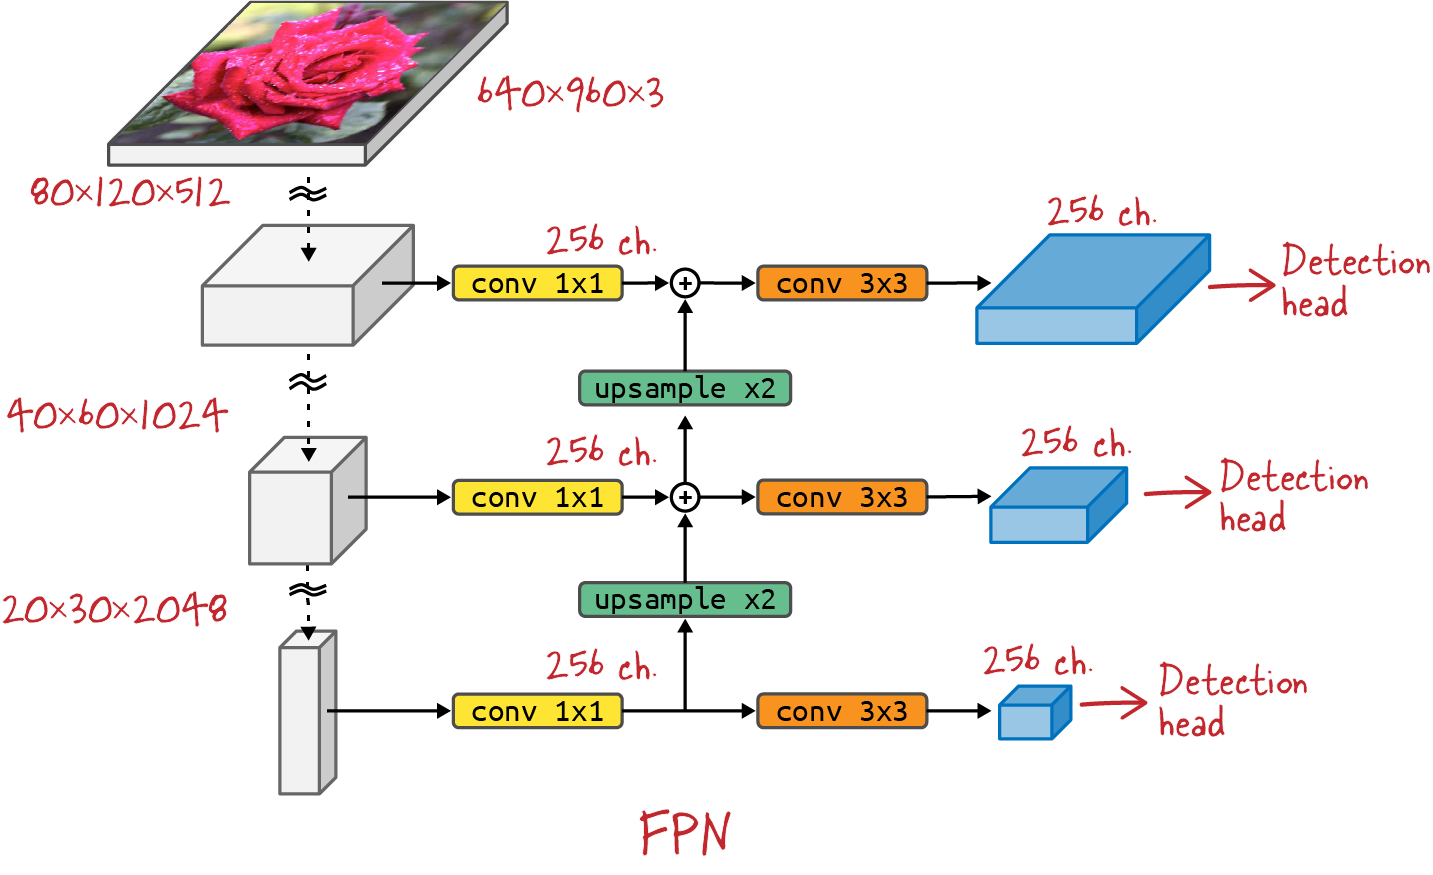

In [ ]:
print(p3.shape)
print(p4.shape)
print(p5.shape)
print(p6.shape)
print(p7.shape)

(8, 56, 56, 256)
(8, 28, 28, 256)
(8, 14, 14, 256)
(8, 7, 7, 256)
(8, 4, 4, 256)


In [ ]:
# Rough From Model Garden FPN

In [ ]:
feats_lateral = {}

for level in range(3, 5 + 1):
  feats_lateral[str(level)] = keras.layers.Conv2D(
      filters=256,
      kernel_size=1,
      padding='same',
      name=f'lateral_{level}')(
          outputs['P'+str(level)])

In [ ]:
feats = {'5': feats_lateral['5']}

In [ ]:
upsampling = keras.layers.UpSampling2D(2)

In [ ]:
for level in range(5 - 1, 3 - 1, -1):
  feat_a = upsampling(feats[str(level + 1)])
  feat_b = feats_lateral[str(level)]
  feats[str(level)] = keras.layers.Add()([feat_a, feat_b])

In [ ]:
for level in range(3, 5 + 1):
  feats[str(level)] = keras.layers.Conv2D(
      filters=256,
      strides=1,
      kernel_size=3,
      padding='same',
      name=f'post_hoc_{level}')(
          feats[str(level)])

In [ ]:
for level in range(5 + 1, 7 + 1):
  feats_in = feats[str(level - 1)]
  if level > 5 + 1:
    feats_in = keras.layers.ReLU()(feats_in)
  feats[str(level)] = keras.layers.Conv2D(
      filters=256,
      strides=2,
      kernel_size=3,
      padding='same',
      name=f'coarser_{level}')(
          feats_in)

In [ ]:
for level in range(3, 7 + 1):
  feats[str(level)] = keras.layers.BatchNormalization(
      axis=-1,
      momentum=0.99,
      epsilon=0.001,
      synchronized=False,
      name=f'norm_{level}')(
          feats[str(level)])

In [ ]:
for key in feats.keys():
  print(feats[key].shape)

(8, 14, 14, 256)
(8, 28, 28, 256)
(8, 56, 56, 256)
(8, 7, 7, 256)
(8, 4, 4, 256)
